# Tutorial: I see your true colors

## Making and enhancing RGB images.

Have you ever heard of the overview effect? It's this state of euphoria that astronauts attain when in space, looking down at Earth, suddenly realizing the absurdity of hate and war, and the significance of life in this universe. We're not going all the way there today, but, wouldn't it be great if you could create your own ocean images that appear like you are in space, looking down? 

“True color” images are often generated with satellite imagery to visualize what an image would look like in real life, without algorithms applied. For oceans, these typically utilize red, green, and blue (RGB) bands from the satellite radiance data at the top of the atmosphere that have been corrected for the angular effects of Rayleigh scattering (also known as surface reflectance, or rhos). PACE now offers a full spectral suite of rhos products across the ultraviolet, visible, and near infrared spectra. Functionally, any three inputs can be supplied to make an “RGB” image (i.e., it does not have to be red, green, and blue), which can help create useful “false color” indices. The full range and resolution of spectral bands offered by the rhos suite are new to the ocean color community. This is an exciting prospect, enabling up to 22,100 possible unique false RGB combinations that can be derived from PACE for teasing out subtle signals of interest. 

NOTE: you will need 7.42GB configuration for this exercise.

By the end of this tutorial, you will have:

> 1. Created a contrast-stretched RGB image from PACE 
> 2. Added a layer of ocean color data on top of the RGB image 

## *Are you ready?*

## Let's go get some data first

Login to NASA Earth Access

In [1]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

Enter your Earthdata Login username:  ryan.vandermeulen@noaa.gov
Enter your Earthdata password:  ········


For these "Level 2" files, we're downloading an individual scene, so feeding it a bounding box will help narrow down the results. Here, I'm looking for a scene off Long Island, June 28, 2024.

In [2]:
bbox = (-74.0, 40.0, -72.0, 41.0)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_SFREFL",
    temporal = ("2024-06-28", "2024-06-28"),
    bounding_box = bbox
)

# Create a fileset
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
fileset 

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240628T160709.L2.SFREFL.V3_0.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240628T174527.L2.SFREFL.V3_0.nc>]

So, there are two of these files. 

I actually want the second (later) one, so when I extract from the fileset later, let's extract "fileset[1]" instead of "fileset[0]" 

## Load up!

In [4]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs

In [5]:
nav = xr.open_dataset(fileset[1], group="navigation_data")
nav = nav.set_coords(("longitude","latitude"))
wave = xr.open_dataset(fileset[1], group="sensor_band_parameters")
wave = wave.set_coords(("wavelength_3d"))
ds = xr.open_dataset(fileset[1], group="geophysical_data")
dataset = xr.merge((ds["rhos"], nav, wave))

#%% Subset to speed things up a bit
rhos_box = dataset.where((
        (dataset["latitude"] > 38.0)
        & (dataset["latitude"] < 42.5)
        & (dataset["longitude"] > -75.5)
        & (dataset["longitude"] < -69.0)),
    drop = True)


## Let's see what it looks like

Typically, unless there is a very strong surface reflectance signal (e.g., algal slick), visual details of the ocean are not easily distinguished from RGB rhos products without some image enhancements. Here, we're going to normalize the arrays, and use a technique known as histogram stretching. You can define the upper and lower percintiles that you want to normalize to below. e.g.: 

lower_percent=1, upper_percent=99
lower_percent=2, upper_percent=98
lower_percent=5, upper_percent=95

Each sequence progressively makes the ocean "pop" more - but keep in mind that you're bright pixels (land) will get pretty washed out the more you emphasize the dark (ocean) features.

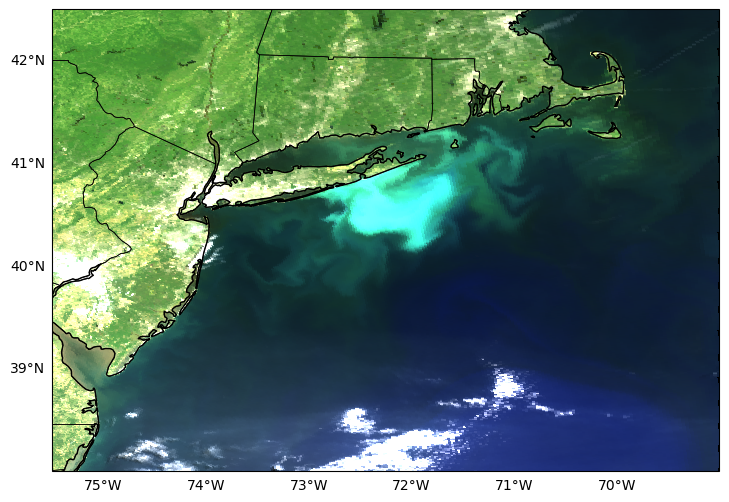

In [14]:
#%% True color image

# Extract the specific wavelengths of the reflectance data
R = rhos_box["rhos"].sel(wavelength_3d=645)  # Red channel at 645 nm
G = rhos_box["rhos"].sel(wavelength_3d=555)  # Green channel at 555 nm
B = rhos_box["rhos"].sel(wavelength_3d=465)  # Blue channel at 465 nm

# Create a mask for valid data (finite values) in all three channels
mask = np.isfinite(R) & np.isfinite(G) & np.isfinite(B)

# Apply the mask: where data is invalid, replace with 0
R = R.where(mask, 0)
G = G.where(mask, 0)
B = B.where(mask, 0)

# Function to normalize the arrays (scale values to range [0, 1])
def normalize(array):
    return (array - array.min()) / (array.max() - array.min())

# Function to apply histogram stretching (scaling based on percentiles)
def stretch(array, lower_percent=1, upper_percent=99):
    """Apply histogram stretching based on percentiles."""
    lower = np.nanpercentile(array, lower_percent)  # Calculate lower percentile
    upper = np.nanpercentile(array, upper_percent)  # Calculate upper percentile
    stretched = (array - lower) / (upper - lower)    # Stretch the data
    return np.clip(stretched, 0, 1)  # Ensure the values are between 0 and 1

# Normalize and stretch the channels (RGB)
R_norm = stretch(R)  # Red channel
G_norm = stretch(G)  # Green channel
B_norm = stretch(B)  # Blue channel

# Stack the normalized channels together to form an RGB image
rgb = np.stack([R_norm, G_norm, B_norm], axis=-1)

# Extract the longitude and latitude values for plotting
lon = rhos_box["longitude"].values
lat = rhos_box["latitude"].values

# Plot the true color image using Cartopy and Matplotlib
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())  # Set up the map projection
gl = ax.gridlines(draw_labels=True)  # Add gridlines with labels
gl.top_labels = False  # Hide top labels
gl.right_labels = False  # Hide right labels
gl.xlines = False  # Hide x-axis lines
gl.ylines = False  # Hide y-axis lines
gl.xlabel_style = {'size': 10}  # Customize label style
gl.ylabel_style = {'size': 10}  # Customize label style

# Add state boundaries and coastlines
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.coastlines()

# ---- Crop the image to preferred location ----
# Plot the RGB composite using pcolormesh and adjust brightness
plt.pcolormesh(lon, lat, np.clip(rgb * 1.5, 0, 1), shading='auto')  # brighten with *1.5
plt.xlabel("Longitude")  # Label the x-axis
plt.ylabel("Latitude")   # Label the y-axis
plt.title("RGB Composite (640, 555, 465 nm)")  # Title the plot
plt.xlim(-75.5, -69.0)  # Set longitude limits (cropping the region)
plt.ylim(38.0, 42.5)    # Set latitude limits (cropping the region)
plt.title('')  # Remove redundant title
plt.show()  # Display the plot

Holy coccolithophore! What you're seeing here is a giant coccolithophore bloom. These phytoplankton create calcium carbonate shells, turning the sea a milky shade. They aren't harmful to local marine life. After they die they sink fast, making them efficient at transporting carbon into the deep ocean. 

## Enhancing ocean color data images with true color

Okay, just to make your ocean color images a little more fun, you can actually grab an ocean color variable and put it on top of the RGB we just created. Let's start with grabbing the chlorophyll data and subsetting it the same way we did with the rhos data. 

In [7]:
bbox = (-74.0, 40.0, -72.0, 41.0)
import xarray as xr
results2 = earthaccess.search_data(
    short_name = "PACE_OCI_L2_BGC",
    temporal = ("2024-06-28", "2024-06-28"),
    bounding_box = bbox
)
fileset2 = earthaccess.open(results2);

# Create a fileset
fileset2 = earthaccess.open(results2);
#ds2 = xr.open_dataset(fileset2[1])
ds_chl = xr.open_dataset(fileset2[1], group="geophysical_data")
chlor_a = xr.merge((ds_chl["chlor_a"], nav, wave))
chlor_box = chlor_a.where((
        (chlor_a["latitude"] > 38.0)
        & (chlor_a["latitude"] < 42.5)
        & (chlor_a["longitude"] > -75.5)
        & (chlor_a["longitude"] < -69.0)),
    drop=True)

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

What is very convenient is that the chlorophyll image has NaNs when data are not present. So, we can just grab the all the valid datapoints using np.isfinite, and plop that right on top of our previous image, preserving the true color image where chlor_a = NaN.

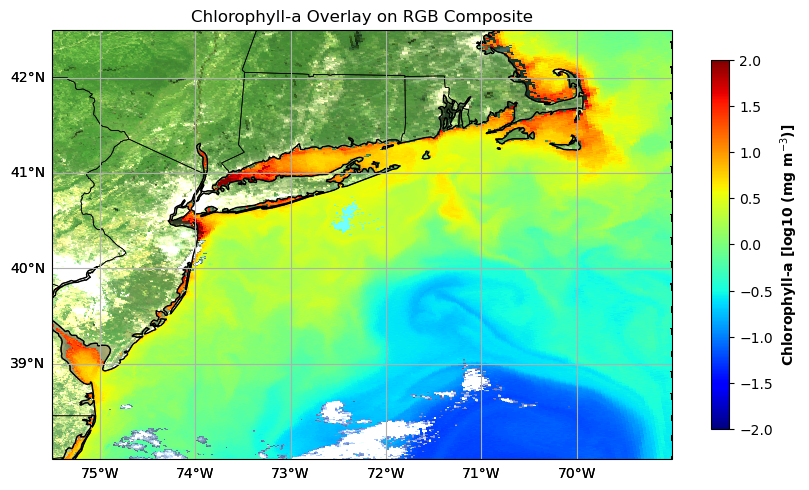

In [8]:
# Normalize chlorophyll-a
chlor_a = chlor_box["chlor_a"]
chlor_mask = np.isfinite(chlor_a)
chlor_display = chlor_a.where(chlor_mask)

# Start figure
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())

# Gridlines and features
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

# Plot RGB background
plt.pcolormesh(lon, lat, np.clip(rgb * 1.5, 0, 1), shading='auto')

# Overlay chlorophyll-a where valid
chlor_plot = ax.pcolormesh(
    lon, lat, np.log10(chlor_display),
    cmap='jet',
    shading='auto',
    vmin=-2, vmax=2
    #alpha=np.where(chlor_mask, 0.7, 0)  # Use alpha mask for transparency
)

# Optional colorbar
cbar = plt.colorbar(chlor_plot, ax=ax, shrink=0.8, pad=0.05)
cbar.set_label('Chlorophyll-a [log10 (mg m$^{-3}$)]', weight='bold')

# Labels and limits
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-75.5, -69.0)
plt.ylim(38.0, 42.5)
plt.title('Chlorophyll-a Overlay on RGB Composite')
plt.show()

## There you have it! 

The surface reflectance products can be very useful because they have minimal atmospheric correction applied, that is, no aerosol subtraction, which is a source of common data quality errors. Some algorithm developers prefer to use rhos in place of remote sensing reflectance, especially for inland water bodies where atmospheric correction can be very challenging, as is the case for cyanobacteria monitoring. Feel free to go back and change the RGB channels to a customized combination, it doesn't have to be red, green, and blue. Or, try reading in Rrs (PACE*AOP files) instead of rhos, and then you can really emphasize ocean features!